# A Resolution for Inaccessibility

The problem that I intend to solve with this project is that of the inherent inaccessibility of government resolutions to the layman due to the often-high complexity of certain issues. Considering the terminology often unique to many topics, often political, and combining that with the lack of familiarity with legal writing and how dense it can become, I believe that there is an unacknowledged barrier between the government and its people when it comes to the motions that may be governing them.

As such, I've decided to help bridge that gap. When the model is given a pre-processed resolution and 'topamount' value, indicating how many topics the model should find within the resolution, the model will return a product comprised of the determined topic phrases and (2 * topamount) clauses from the resolution that best represent and summarize the topic. This product is created using NLP and supervised learning methods that ensure that the overall ideas and topics within the resolution are presented as accurately as possible and with as much information maintained as possible, while effectively condensing the resolution to key points in such a way that it is much more accessible and less overwhelming to the average person.

In a production-like environment, this model would run phenomenally, as it is able to run from start to finish in 10 - 45 seconds depending on the length of the resolution. Thus, if used to create a mass amount of SparkNotes-ized resolutions, it would be able to run incredibly quickly. Yet, to maintain it going forward, I would like to implement either extractive or abstract text summarization for each summary sentence as a means of sidestepping legislative terminology and structuring even further.

### Steps for Necessary Resolution Pre-Processing:

1. Find resolution on congress.gov with 'Whereas' and 'Resolved' clauses. **Must have both**.
2. On resolution page, go to 'Text' tab.
3. On 'Text available as' line, click 'TXT'.
4. Copy resolution text starting from first 'Whereas' and ending at the period of the final 'Resolution' line. 
   **Note**: Some resolutions include an 'Attest' section at the end. ***Do not include that.***
5. Paste the text into Word.
6. Click on the Replace function found on the right-most side of the Home toolbar, or hit Ctrl + H.
7. Enter '        ' (eight spaces used for line indents) into 'Find what'.
8. Enter ' ' (a single space) into 'Replace with'.
9. Click 'Replace all'.
10. Enter '^p' (line break) into 'Find what'.
11. Enter ' ' (single space) into 'Replace with'.
12. Click 'Replace all'.
13. Save the document as a *Plain Text (.txt)*. **This model will not work if the document is saved as a Word document.**
14. Read the large, bolded text a few cells below.
15. Enter the desired value for 'topamount'.
16. Replace filepath for variable 'file' a few cells below with where your file is located.
17. Under 'Cell', click 'Run All.'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import spacy
import en_core_web_sm
from collections import Counter
from sklearn.svm import SVC
import networkx as nx
from string import punctuation
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score as ps
from sklearn.metrics import recall_score as re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
from sklearn.manifold import TSNE
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

## Below, enter the number of topics (topamount = n) you would like. 
The output you will receive will give up to 2 * n sentences that best summarize the given resolution. There will be up to n sentences for the 'Whereas' clauses, and up to n sentences for the 'Resolved' clauses. 

It is recommended that topamount is set to either 2 or 3 for the best summarization. The model can handle more, however, if it cannot find an adequate amount of clauses in either the 'Whereas' or 'Resolved' sections for a topic it chooses, a summarization sentence will not be given for the section. This generally starts happening when topamount > 5.

While the model is able to handle higher topamount values and produce summary sentences for topics it has adequate clauses for, this does not mean that you are receiving the best possible summary. This will be indicated by accuracy scores lower than 0.66.

**Do not use 1, the code will not work, and that's just the entire resolution.**

In [2]:
topamount = 3

### Text Processing and Initial Dataframe Creation

The following cells help to remove any cases of excess spaces, allow us to split the resolution into 'Whereas' and 'Resolved' sections based on a phrase present right between them, and then further split each part each into clauses.

These two parts are defined not just by whether they come before or after the phrase, "Now, therefore, be it Resolved", but by the fact that they also comprised of different types of clauses, which each have a different function. 

In the 'Whereas' section, each clause acts to present a piece of evidence as to the urgency and relevancy of the topic(s) at hand. These clauses come first as they lay out the platform which justify the various 'calls to action' and solutions presented within the clauses of the 'Resolved' section.

In [3]:
file = open('C:\\Users\\Trevor\\Documents\\Thinkful\\text.txt',mode='r')
text = file.read()
file.close()
text = " ".join(text.split())
text

"Whereas in recent decades the Rohingya people have lost, through systematic discrimination by Burmese national, state, and local authorities, a range of civil and political rights, including citizenship, and face barriers today such that they have been rendered stateless; Whereas the Burmese military and security forces have committed numerous crimes against civilians over many years in Burma's Rakhine, Shan, Kachin, and Karen States; Whereas beginning August 25, 2017, the Burmese military and security forces, as well as civilian mobs, carried out widespread attacks, rapes, killings, and the burning of villages throughout Rakhine State resulting in approximately 730,000 Rohingya fleeing to Bangladesh and bringing the total Rohingya refugee population in Cox's Bazar to over 900,000; Whereas on November 14, 2018, Vice President Mike Pence said, ``This is a tragedy that has touched the hearts of millions of Americans. The violence and persecution by military and vigilantes that resulted 

In [4]:
temp = text.split('Now, therefore, be it Resolved, ')
whereas, resolved = temp[0], temp[1]

In [5]:
wlist = whereas.split('; ')
rlist = resolved.split('; ')

Here, the dataframe is being made by making lists of the clauses in order as they appear in the resolution, while also making a list of if they are 'Whereas' or 'Resolved'.

For ease of topic labeling later on, a row is also being made that contains only the nouns and adjectives present in the clauses as they appear. I've also included two features that show how much of the clause is made up of nouns and adjectives.

In [6]:
nlp = spacy.load("en_core_web_sm")

ctype = []
clauses = []

for i in wlist:
    if i[0] == '(':
        ctype.append('W')
        clauses.append(i[4:].rstrip(punctuation))
    elif i[0:4] == 'and ':
        ctype.append('W')
        clauses.append(i[4:].rstrip(punctuation))
    else:
        ctype.append('W')
        clauses.append(i.rstrip(punctuation))
    
for j in rlist:
    if j[0] == '(':
        ctype.append('R')
        clauses.append(j[4:].rstrip(punctuation))
    elif i[0:4] == 'and ':
        ctype.append('R')
        clauses.append(j[4:].rstrip(punctuation))
    elif j[0:5] == 'and (':
        ctype.append('R')
        clauses.append(j[7:].rstrip(punctuation))
    else:
        ctype.append('R')
        clauses.append(j.rstrip(punctuation))

res = pd.DataFrame()
res['Clause'] = np.array(clauses)
res['Type'] = np.array(ctype)
res.index = res.index + 1

test = res.copy()
nostop = []

for x in clauses:
    y = ' '.join([str(word) for word in nlp(x) 
                  if word.is_stop==False and (word.pos_=='NOUN' 
                                              or word.pos_=='ADJ')])
    nostop.append(str(y))
    
res['Cleaned'] = nostop

noun = []
adj = []

for x in clauses:
    n = [word for word in nlp(x) if word.pos_ == 'NOUN']
    a = [word for word in nlp(x) if word.pos_ == 'ADJ']
    noun.append(len(n) / str(x).count(' '))
    adj.append(len(a) / str(x).count(' '))
    
res['Noun Makeup'] = noun
res['Adjective Makeup'] = adj

res

,Clause,Type,Cleaned,Noun Makeup,Adjective Makeup
1,"Whereas in recent decades the Rohingya people have lost, through systematic discrimination by Burmese national, state, and local authorities, a range of civil and political rights, including citizenship, and face barriers today such that they have been rendered stateless",W,recent decades people systematic discrimination Burmese national state local authorities range civil political rights citizenship barriers today stateless,0.289474,0.210526
2,"Whereas the Burmese military and security forces have committed numerous crimes against civilians over many years in Burma's Rakhine, Shan, Kachin, and Karen States",W,Burmese military security forces numerous crimes civilians years,0.260870,0.130435
3,"Whereas beginning August 25, 2017, the Burmese military and security forces, as well as civilian mobs, carried out widespread attacks, rapes, killings, and the burning of villages throughout Rakhine State resulting in approximately 730,000 Rohingya fleeing to Bangladesh and bringing the total Rohingya refugee population in Cox's Bazar to over 900,000",W,Burmese military security forces civilian mobs widespread attacks rapes killings burning villages total refugee population,0.220000,0.080000
4,"Whereas on November 14, 2018, Vice President Mike Pence said, ``This is a tragedy that has touched the hearts of millions of Americans. The violence and persecution by military and vigilantes that resulted in driving 700,000 Rohingya to Bangladesh is without excuse",W,tragedy hearts millions violence persecution military excuse,0.170732,0.000000
5,"Whereas to date, though the refugee crisis is not of their making, the Government of Bangladesh has generously accommodated the rapid and massive influx of Rohingya refugees into Cox's Bazar",W,date refugee crisis making rapid massive influx Rohingya refugees,0.206897,0.103448
6,Whereas the Government of Bangladesh continues to express concern about the lack of accountability for the perpetrators of these crimes and the need to find durable solutions,W,concern lack accountability perpetrators crimes need durable solutions,0.269231,0.038462
7,"Whereas in June 2018, it was announced that the United Nations and the Government of Burma had reached an agreement for the ``voluntary, safe, dignified and sustainable'' return of Rohinyga to Burma",W,agreement ` voluntary safe dignified sustainable return,0.096774,0.129032
8,"Whereas that agreement was contingent upon the provision of unimpeded access to northern Rakhine by United Nations High Commission on Refugees (UNHCR) and United Nations Development Program (UNDP) in order to verify the necessary conditions on the ground for such voluntary, safe, dignified, and sustainable returns",W,agreement contingent provision unimpeded access northern order necessary conditions ground voluntary safe dignified sustainable returns,0.155556,0.200000
9,"Whereas Burma's civilian government, led by State Counsellor Aung San Suu Kyi and President Win Myint, has not yet taken the necessary steps to address the violence directed against the Rohingya and has failed to create the necessary conditions for returns, including by actively impeding access to northern Rakhine by UNHCR, UNDP, humanitarian organizations, and journalists",W,civilian government necessary steps violence necessary conditions returns access northern humanitarian organizations journalists,0.145455,0.090909
10,"Whereas on August 24, 2018, the United Nations International Fact Finding Mission on Myanmar released a preliminary report stating that, ``The Mission concluded . . . that there is sufficient information to warrant the investigation and prosecution of senior officials in the Tatmadaw chain of command, so that a competent court can determine their liability for genocide in relation to the situation in Rakhine State",W,preliminary report sufficient information investigation prosecution senior officials chain command competent court liability genocide re

### Visualization and Exploration

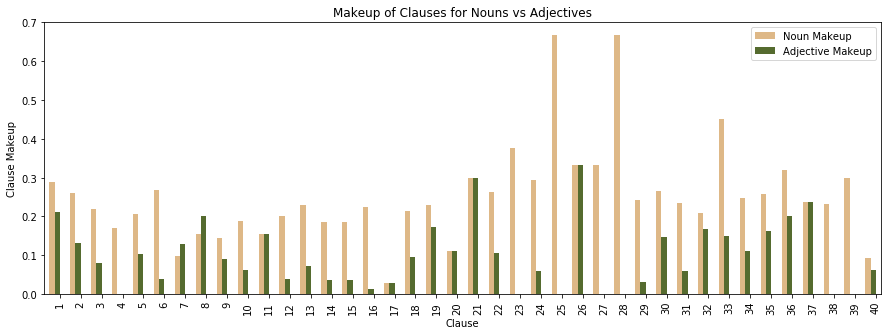

In [7]:
ax = res[['Noun Makeup', 'Adjective Makeup']].plot(kind='bar', 
                                                   color=['burlywood', 'darkolivegreen'], position=1, figsize = (15, 5), 
                                                   title = 'Makeup of Clauses for Nouns vs Adjectives')
ax.set_xlabel("Clause")
ax.set_ylabel("Clause Makeup")

plt.show()

Interestingly enough, we can see that the clauses have many more nouns throughout them than they do adjectives. In some cases, adjectives reach up to equal the amount of nouns that there are, though the majority of them lie around 50% or under.

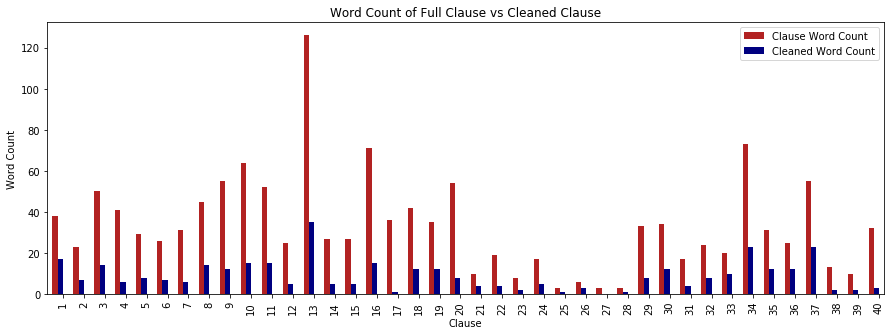

In [8]:
clacount = [x.count(' ') for x in res.Clause.values]
clecount = [x.count(' ') for x in res.Cleaned.values]

vis = pd.DataFrame(np.array([clacount, clecount]).T, columns = ['Clause Word Count', 'Cleaned Word Count'], 
                      index = range(1, len(clacount) + 1))


ax = vis[['Clause Word Count', 'Cleaned Word Count']].plot(kind='bar', 
                                                           color=['firebrick', 'navy'], 
                                                           position=1, figsize = (15, 5), 
                                                           title = 'Word Count of Full Clause vs Cleaned Clause')
ax.set_xlabel("Clause")
ax.set_ylabel("Word Count")

plt.show()

The above visualization helps greatly in understanding why it's necessary to include a 'cleaned' version of the clause in the dataframe right from the start. We want our topics to be as relevant, concise, and detailed as possible, and thus, we're only going to want words that are meaningful.

Hence, it's very necessary that we make a trimmed-down version of our clauses that only hold nouns and adjectives, as these are actually descriptive towards a topic, as opposed to a topic that contains "the", "and", or "of". 

This also helps to point out just how much of regular writing, especially legislative writing, is packed with stop words and words that aren't always that helpful to us. However, stop words are necessary in structuring our sentences in ways that we can actually understand the relationshiop between all of the nouns and adjectives as opposed to facing a slurry of things and descriptors. That is why we still include the original clause in our data.

So far, with just a clause, its cleaned version, and a section type, we can't say so much. Thus, we must start creating topics, and a way to label clauses as topics. To be able to label topics, we'll need to create a large amount of features, which we can thankfully do through the use of NLP methods such as ngram creation, keyword summarization, text ranking, BagOfWords, and tf-idf. This can then allow us to create even more features, such as weighted and unweighted term presence sums.

In [9]:
textok = nlp(text)
sentences = clauses

Before we begin actually determining our topics, it's worth visually investigating the most common, and thus most important, words in the resolution. This will help to give us an idea of what we're in for and what we'll be working with thematically.

Since stopwords are certainly going to be very common in our resolution, it's important that we filter them out so that we only see the most important and relevant terms.

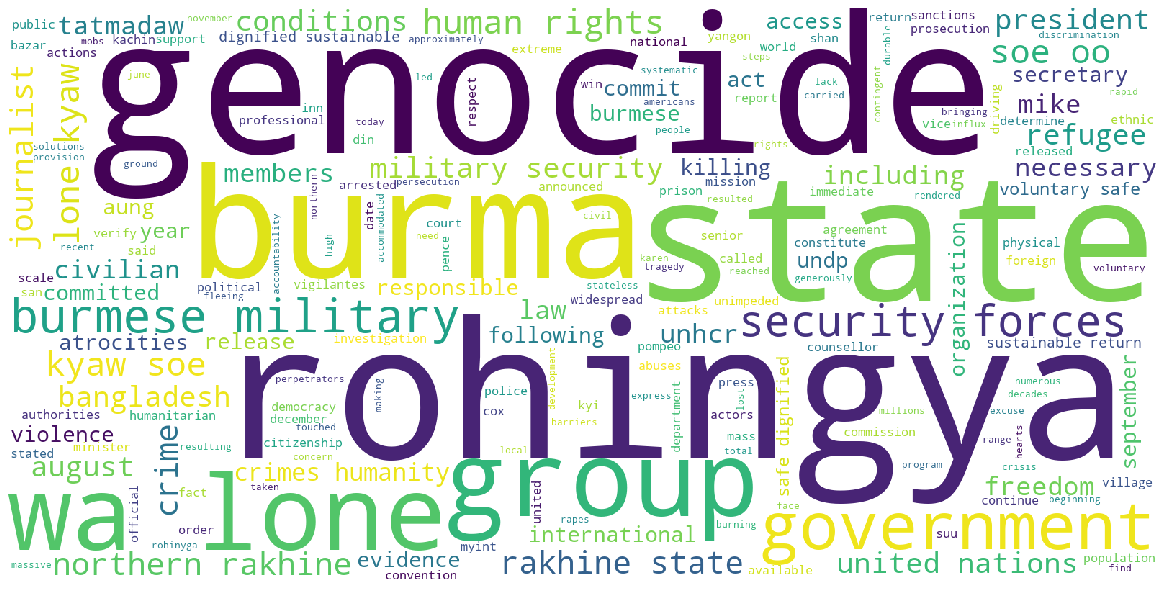

In [10]:
textcloud = [word for word in textok if word.is_stop==False]

stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(str(textcloud).lower()) 

plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Topic Creation

In the following cell, the possible best topics are compiled based on 2- and 3-grams. 2- and 3-grams are a form of n-gram, which is a sequence of 'n' items taken generally from a piece of text or speech. In our case, we are going to be taking sequences of lengths 2 and 3 from the resolution and determining which are the most relevant and most important, and thus will be acting as a representative of a topic within the resolution.

Based on testing various resolutions, while top 1-grams to tend to rank somewhat higher than other n-grams, they are much too vague to effectively represent a well-defined topic with consideration to feature. On the other hand, n-grams with n > 3 are too large and overspecified to act properly as a topic. Thus, only 2- and 3-grams are used, with the top 'topamount' topic phrases being chosen to aid in topic labeling.

In [11]:
text_filt = [word for word in textok if word.is_stop==False and (word.pos_=='NOUN' or word.pos_=='ADJ')]
bestrank = []

for z in range(2, 4):

    need = []
    for i in range(len(text_filt) - (z - 1)):
        t = [str(text_filt[i]) for i in range(i, i + z)]
        x = ' '.join(t)
        need.append(x)

    words=set(need)

    adjacency=pd.DataFrame(columns=words,index=words,data=0)

    for i,word in enumerate(need):
        if any([word == item for item in need]):
            end=max(0,len(need)-(len(need)-(i+11)))
            nextwords=need[i+1:end]
            inset=[x in need for x in nextwords]
            neighbors=[nextwords[i] for i in range(len(nextwords)) if inset[i]]
            if neighbors:
                adjacency.loc[word,neighbors]=adjacency.loc[word,neighbors]+1

    nx_words = nx.from_numpy_matrix(adjacency.values)
    ranks=nx.pagerank(nx_words, alpha=.85, tol=.00000001)

    ranked = sorted(((ranks[i],s) for i,s in enumerate(words)),
                    reverse=True)

    for gram in ranked[:5]:
        bestrank.append(gram)
            
grams = sorted(bestrank, key = lambda i: i[0], reverse = True)

bestgram = [grams[0]]
for i in grams[1:]:
    count = 0
    for j in bestgram:
        x = max([i[1], j[1]], key = len)
        y = min([i[1], j[1]], key = len)
        if y in x:
            count += 1
        else:
            continue
    if count == 0:
        bestgram.append(i)
    else:
        continue
            
bestgram = bestgram[:topamount]

print('Top ' + str(topamount) + ' n-grams, To Be Used as Topics for Clause Classification')
print(bestgram)

Top 3 n-grams, To Be Used as Topics for Clause Classification
[(0.013847132820050808, 'security forces'), (0.013702594064347822, 'human rights'), (0.01274057943372503, 'Burmese military')]


In [12]:
type(bestgram[0][1])

str

### Topic Labeling and Training Set Creation

Now that we have our topic phrases, we can begin creating our training set for future modeling and prediction. This will be done by taking each topic phrase, and then making an array for it comprised of binary values corresponding to each clause, stating whether or not the cleaned clause contains the topic phrase. The binary values in each array will be 0 and a value of the form 1 + 2n, with n indicating the index of the topic phrase in the 'bestgram' list. We're using the cleaned clauses in this instance since the topic phrases were taken from the cleaned resolution.

After each array is made, they are then all added together. By summing the topic arrays, we can determine if a clause contains no topic phrases, a single topic phrase, or multiple. In the case of using topamount = 3, there would be three topics, such that the summed array would be composed of 0, 1, 3, 5, and any possible combination of 1, 3, and 5. 

Since we want our training set to be comprised only of clauses containing, and thus representing, a single topic phrase, we then iterate through the summed array to check if any values isn't 0, 1, 3, or 5. If not, we then set it back to 0 so that the topic it falls into can be more accurately determined via modeling. 

The reason we're using 1, 3, 5 as opposed to 1, 2, 3 is that, if the topics were labeled here as 1, 2, 3, some combinations would be 3, 4, or 5. We would be able to reset the 4s and 5s, but we wouldn't be able to tell if the 3s were real 3s, or a combination of 1 and 2. This mislabel would then not only be allowed to stay as a 3, but the clause would also be set as a topic it doesn't represent, and thus damage the value of our training set.

In [13]:
topics = []

for i in range(len(bestgram)):
    temp = []
    for x in res.Cleaned.values:
        if str(bestgram[i][1]) in x:
            temp.append(1 + (2*i))
        else:
            temp.append(0)
    topics.append(np.array(temp))

y = topics[0]

for i in range(1, len(bestgram)):
    y = y + topics[i]

labels = list(y)

for index, lbl in enumerate(labels):
    if lbl not in list(range(1, 1 + 2 * topamount, 2)):
        labels[index] = 0
        
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 1, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now that we've created our training set labels, we can set it as our 'Topic' feature for now despite not having all of the necessary values.

In [14]:
res['Topic'] = np.array(labels).T

### Feature Creation via Bag of Words and tf-idf

Now we're creating our Bag of Words (BoW) and BoW Features functions. BoW allows us to find the most common words in our resolution up to a certain limit, and BoW Features, after taking in the clauses, allows us to create a dataframe where the words from BoW are the columns, in which the columns represent how many times the particular word appears in each clause.

The use of these two NLP models allows us to create hundreds of features for our resolution that are necessary towards having as high of accuracy as possible in further labeling the topics of our clauses.

In [15]:
def bag_of_words(text):
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    return [item[0] for item in Counter(allwords).most_common(2000)]
    
def bow_features(sentences, common_words):
    
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        for word in words:
            df.loc[i, word] += 1
        
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

In the following few cells, we're actually implementing BoW and BoW Features on our resolution and clauses to create the necessary data for our future modeling.

In [16]:
textwords = bag_of_words(textok)
tempsent = [nlp(sent)[:] for sent in sentences]

textsent = pd.DataFrame()
textsent[0] = np.array(tempsent)
textsent[1] = res.Type.reset_index(drop = True)

In [17]:
word_counts = bow_features(textsent, set(textwords))

Processing row 0


In [18]:
temp = list(word_counts.drop(columns = ['text_sentence', 'text_source']).columns)

col = [word for word in temp if len(word) > 1]

While having our full BoW Features data is very essential towards our modeling, we can make this data even more meaningful through the application of tf-idf weighted values to our BoW dataframe.

tf-idf (term frequency - inverse document freequency) grants us weighted values that are representative of a statistical measure used to evaluate how important a word is to a document in a collection, or in our case, the 'whereas' and 'resolved' sections. As the count of a word rises, the importance increases proportionally and is offset by the frequency of the word in the overall corpus, being the resolution. 

By multiplying these weights to our BoW features, we'll end up receiving an entire dataframe of values that correspond not only to how many times a word appears per clause, but also corresponds to how important the word is to the part the clause is present in. 

In [19]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=1, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


vectors = vectorizer.fit_transform([whereas, resolved])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

df = pd.DataFrame(denselist, columns=feature_names)

Now that our tf-idf values have been created, we can start working on creating our final features. The first thing we need to consider is that the BoW Features and tf-idf dataframe don't contain entirely the same words. Thus, we must find the common words between the two and use only those as words as features for our dataframe.

In [20]:
temp = (list(word_counts.columns) + list(df.columns))
common = [word for word in temp if (word in list(word_counts.columns) 
                                    and word in list(df.columns)
                                   and word != 'Whereas')]

newdf = word_counts[common].copy()
newdf.index = newdf.index + 1
newdf['Type'] = res.Type

Now we're splitting up our tf-idf dataframe into two based on clause type for ease of access.

In [21]:
w = ((df.copy().T)[0]).copy().T
wval = pd.DataFrame(w).copy().T

r = ((df.copy().T)[1]).copy().T
rval = pd.DataFrame(r).copy().T

rval = rval.reset_index(drop = True)

Now that we have our BoW Features dataframe and our tf-idf dataframes, what's we're doing below is iterating through every cell in the BoW dataframe, and multiplying it by the corresponding weighted tf-idf value based on the word representing the feature and whether the clause at hand is 'Whereas' or 'Resolved'.

In [22]:
for i in range(1, newdf[newdf.Type == 'W'].shape[0] + 1):
    for col in common:
        if wval.loc[0, col] == 0:
            continue
        elif list(newdf.loc[i, col])[0] == 0:
            continue
        else:
            newdf.loc[i, col] = wval.loc[0, col] * newdf.loc[i, col]
            
for i in range(newdf[newdf.Type == 'W'].shape[0] + 1, newdf.shape[0] + 1):
    for col in common:
        if rval.loc[0, col] == 0:
            continue
        elif list(newdf.loc[i, col])[0] == 0:
            continue
        else:
            newdf.loc[i, col] = rval.loc[0, col] * newdf.loc[i, col]

Now that we have a good few hundred features under our belt for topic value predictions, we may as well add a few more relevant ones for good measure.

In [23]:
newdf['Col Sum'] = newdf[common].sum(axis = 1)
newdf['Col Count'] = newdf[common].astype(bool).sum(axis=1)
newdf['Word Count'] = np.array([len(sent) for sent in tempsent])

Since we have all of our features now, we can now combine our original clause dataframe with our BoW/tf-idf dataframe such that we can have all of the necessary modeling data in a single space.

In [24]:
newdf = newdf.drop(columns = ['Type'])

newres = pd.concat([res, newdf], axis = 1)

### Topic Predictions and Model Validation

Following the creation of our features, we can finally start on our modeling. As we don't actually have our full topic values yet, we must manually create our training and test sets, which are created based on if a clause has a non-zero topic value or not.

In [25]:
X_train = newres[newres.Topic != 0].copy().drop(columns = ['Clause', 'Cleaned', 'Type'])
y_train = newres[newres.Topic != 0]['Topic'].copy()

X_test = newres[newres.Topic == 0].copy().drop(columns = ['Clause', 'Cleaned', 'Type'])
y_test = newres[newres.Topic == 0]['Topic'].copy()

For making the topic predictions, I've decided that SVM is by far the best classifier to use in filling out our topic values. The reasons are the following:

1. SVM is particularly useful in dealing with very high dimensionality (necessary since we have hundreds of features).
2. SVM is very effective when the number of features is greater than the number of training observations (hundreds vs often less than ten)
3. The hyperplane used in SVM is affected by only the support vectors, thus outliers have less impact (necessary since outliers could heavily damage our small training set's usability).
4. SVM consistently receives much higher accuracy scores across various resolutions and topamount values than other classifiers, such as decision trees, random forests, and gradient boosted decision trees.

In addition to these reasons as to why SVM is the best classifier for our situation, the current hyperparameter settings have been tested among other settings and have consistently received the highest accuracy scores while also benefitting the test set with a more balanced spread of topic labels unlike the possibly imbalanced training data.

While most resolutions are relatively short (less than 75 clauses), some are much longer, and thus, require a different kernel parameter to be used to combat overfitting that reduces predictions to a single topic label. As such, if the model runs into this issue, a model with a kernel better set towards larger resolutions will be used instead.

Once the prediction has been made for the unlabeled subset, the prediction is then set as the subset's topic values.

In [26]:
topic = list(newres.columns)

svc = SVC(kernel = 'linear',
          gamma = 'auto',
          probability = True, 
          class_weight = 'balanced')

svc.fit(X_train, y_train)
prediction = svc.predict(X_test)

if len(set(prediction)) == 1:
    svc = SVC(kernel = 'rbf',
          gamma = 'auto',
          probability = True, 
          class_weight = 'balanced')
    
    svc.fit(X_train, y_train)
    prediction = svc.predict(X_test)
else:
    prediction = prediction

In [27]:
newres.loc[newres.Topic == 0, 'Topic'] = prediction

Now that we have our predictions, we should certainly run an accuracy score to see how well-fit our model is. Yet, to get an accuracy score, we need both the original label values and the prediction, and we don't have those original label values.

However, we shouldn't fret, as what we can do to still receive a useful metric is do an accuracy test, but in reverse. To do this, we'll train off the newly labeled subset, then predict the labels for the originally labeled subset, and run an accuracy score on the prediction and original labels. 

While this certainly isn't an orthodox accuracy score, it still allows us to receive a necessary metric that we can use to evaluate just how well-fit our freshly-labeled clauses are to the topics they've been placed in based off of feature similarity to the originally labeled subset. Additionally, since our testing sets are often imbalanced, we will be using a balanced accuracy score as opposed to a regular accuracy score. It's important to know that as the topamount value increases, notably past 4, the accuracy score quickly drops since there will be less and less clauses for each topic to work with from our original training set.

Additionally, we can use metrics such as weighted precision and recall as well to help build an idea of how well-defined our topics are within our features. As a reminder, precision is the ability of the classifier not to label as positive a sample that is negative, while recall is the ability of the classifier to find all positive samples.

Through the aid of a confusion matrix as well, we'll be able to determine where our model was performing well and where our model had run into any issues with topic mis-labeling.

In [28]:
Xp_test = newres.copy().loc[list(X_train.index)].drop(columns = ['Clause', 'Cleaned', 'Type'])
yp_test = newres['Topic'].copy().loc[list(X_train.index)]

Xp_train = newres.copy().loc[list(X_test.index)].drop(columns = ['Clause', 'Cleaned', 'Type'])
yp_train = newres['Topic'].loc[list(X_test.index)].copy()

The balanced accuracy of our topic labeling is: 0.89
The weighted precision of our topic labeling is: 0.92
The weighted recall of our topic labeling is: 0.83


C:\Users\Trevor\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


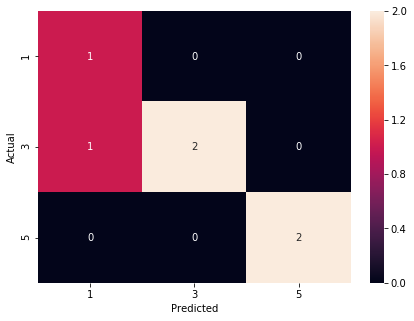

In [29]:
svc.fit(Xp_train, yp_train)
pprediction = svc.predict(Xp_test)

acc = balanced_accuracy_score(yp_test, pprediction)
prec = ps(yp_test, pprediction, labels = list(set(labels)), average = 'weighted', zero_division = 0)
rec = re(yp_test, pprediction, labels = list(set(labels)), average = 'weighted')
cross = pd.crosstab(yp_test, pprediction, rownames=['Actual'], colnames=['Predicted'])

print('The balanced accuracy of our topic labeling is: ' + str(round(acc, 2)))
print('The weighted precision of our topic labeling is: ' + str(round(prec, 2)))
print('The weighted recall of our topic labeling is: ' + str(round(rec, 2)))
plt.figure(figsize = (7,5))
sns.heatmap(cross, annot=True)

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

Having our full topic values finally, we may as well run some clustering algorithms just to see how well clustered our topics may be. In particular, we'll be running a dimensionality reduction algorithm due to how high our dimensionality is. 

However, due to Python contraints, it's impossible to render the full colorized image that labels each datapoint with a color by its topic value due to how incredibly massive the image is. As such, we are only able to receive the single-color scatterplot, which will still allow us to see how our data is clustered.

[t-SNE] Computing 39 nearest neighbors...
[t-SNE] Indexed 40 samples in 0.000s...
[t-SNE] Computed neighbors for 40 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 40 / 40
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.005s
[t-SNE] Iteration 50: error = 44.0913048, gradient norm = 0.5451741 (50 iterations in 0.026s)
[t-SNE] Iteration 100: error = 43.6350708, gradient norm = 0.4712294 (50 iterations in 0.028s)
[t-SNE] Iteration 150: error = 45.8269119, gradient norm = 0.4376297 (50 iterations in 0.020s)
[t-SNE] Iteration 200: error = 45.4021759, gradient norm = 0.4804423 (50 iterations in 0.018s)
[t-SNE] Iteration 250: error = 42.5754242, gradient norm = 0.6931014 (50 iterations in 0.017s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.575424
[t-SNE] Iteration 300: error = 0.6955328, gradient norm = 0.0010463 (50 iterations in 0.017s)
[t-SNE] KL divergence after 300 iterations: 0.695533


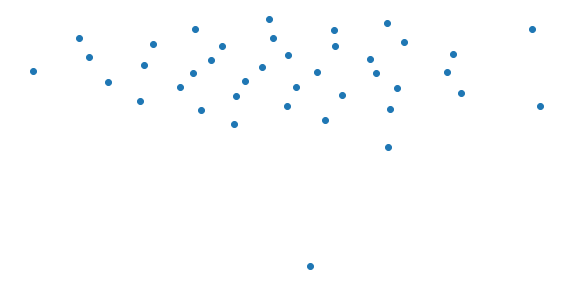

In [30]:
X = newres.drop(columns = ['Clause', 'Cleaned', 'Type'])
Y = newres['Topic']

tsne = TSNE(n_components=2, verbose=2, perplexity=150, n_iter=300)
tsne_results = tsne.fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

### Final Product Creation

Now that we have a fully-labeled topic column, we can begin working on the final product. Since the same amount of clauses will be pulled from each part of the resolution, we may as well split our dataframe based on type. 

In [31]:
wres = newres[newres.Type == 'W'].copy().reset_index(drop = True)
rres = newres[newres.Type == 'R'].copy().reset_index(drop = True)

In [32]:
counter = TfidfVectorizer(lowercase=False, 
                          stop_words=None,
                          ngram_range=(1, 3), 
                          analyzer=u'word', 
                          max_df=1, 
                          min_df=1,
                          max_features=None, 
                          vocabulary=None, 
                          binary=False)

What's happening here is that we're essentially creating (2 * topamount) topic subsets of clauses from the resolution based on part and topic. For each subset, TextRank is being applied to it to find the clause that best represents, and thus best summarizes, the entire topic subset. In some instances, however, specifically if the topamount value is too high, a part may not have any clauses for that topic, and thus a summary clause cannot possibly be provided for that topic in that part.

Once all the summary clauses have been received, they are then ordered by the order they appear in in the resolution. Then, the relevant topics, ordered summary clauses, and how many max clauses there may have been vs how many there are is returned to the user.

In [33]:
parts = [wres, rres]

lines = []

for part in parts:
    for topic in range(1, 2 * topamount, 2):
        
        topsent = list(part[part.Topic == topic].Clause.values)
        
        if len(topsent) > 0:

            data_counts = counter.fit_transform(topsent)

            similarity = data_counts * data_counts.T

            nx_graph = nx.from_scipy_sparse_matrix(similarity)
            ranks=nx.pagerank(nx_graph, alpha=.85, tol=.00000001)

            ranked = sorted(((ranks[i],s) for i,s in enumerate(topsent)),
                            reverse=True)
            lines.append(ranked[0][1])
            
        else:
            continue

In [34]:
summ = []

for x in lines:
    y = newres.index[newres['Clause'] == x]
    summ.append((x.capitalize(), y[0]))
    
summ = sorted(summ, key = lambda i: i[1], reverse = False)
summ = [x[0] for x in summ]

best = [x[1] for x in bestgram]
print(best)
print('')

for i, line in enumerate(summ):
    print(str(i+1) + '. ' + line)
    print('')
    
print('Max amount of clauses returned is ' + str(topamount * 2) + ', returned ' + str(len(summ)) + '.')

['security forces', 'human rights', 'Burmese military']

1. Whereas to date, though the refugee crisis is not of their making, the government of bangladesh has generously accommodated the rapid and massive influx of rohingya refugees into cox's bazar

2. Whereas on september 3, 2018, yangon northern district judge ye lwin ruled that wa lone and kyaw soe oo breached the colonial-era official secrets act during their investigation into the massacre in inn din and subsequently sentenced them each to 7 years in prison with hard labor, despite admissions by the police under oath in court that the documents in question were planted with the journalists as a front for their arrest

3. Whereas the united nations convention on the prevention and punishment of the crime of genocide, signed at paris december 9, 1948 declares that ``means any of the following acts committed with the intent to destroy, in whole or in part, a national, ethnical, racial or religious group, as such: (a) killing member

### Conclusion

As a brief recap, the intent of the product of this model is present and summarize the main topics and stances within the resolution to the highest possible accuracy and with as much information maintained as possible, while effectively condensing the resolution to key points in such a way that it is much more accessible and less overwhelming to the average person.

I am quite happy to see that the SVM models have been performing so consistently well, with their weakest metrics never falling below 0.67 and commonly falling between 0.8 - 0.9. In particular, allowing SVM to adapt its kernel based on if it was heavily underfitting (shown by it only predicting a single class, a result of the 'linear' kernel not working well with larger datasets) allows for the overall model to have a much greater use among longer resolutions by providing metrics that are just as consistently high as those of shorter resolutions. I am also quite happy that through the use of the balanced class weight parameter, I was able to further negate issues of topic prediction underfitting by allowing topics with less observations than others to have more power in being predicted, and thus allow for more clauses to be labeled as such. Through both of these considerations, I'm able to receive much stronger metrics due to more balanced and properly-labeled classes overall, and thus a final product that is as high quality as possible.

The primary way I've considered further raising metrics would be to continue working on my training set creation method in such a way that I'm able to build a larger training set overall while maintaining a distribution of topic labels that is relatively balanced while still making sure that the labels are accurately placed.

While not metric-oriented, two future additions that I'd like to work on would be to implement extractive text summarization and abstractive text summarization. Through extractive TS, I believe that the final product would be even more effective in maintaining as much information as possible due to the creation of unique sentences comprised of various phrasings from each topic subset. Through abstractive TS, not only would the final product be comprised of unique sentences made to maintain as much information as possible, but they would also be made independently from the clauses of the topic subsets in such a way that they would be able to further remove themselves from the inherent inaccessibility of legislative writing, which would still be present in extractive TS due to the product being made from the clauses themselves.